# TIMES BETWEEN STOPS ANALYSIS

In [2]:
import pandas as pd
pd.set_option("display.precision", 3)
import numpy as np
import json

import datetime
from datetime import timedelta

import statistics
from statistics import mean
import math

from pandarallel import pandarallel
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
pandarallel.initialize()

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
pio.templates.default = 'plotly_white'

import scipy
from scipy import stats
import statsmodels.api as sm
import pylab
from scipy.stats.distributions import chi2

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
#FUNCTIONS
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    
    
    N_b = x.shape[0]
    N_w = y.shape[0]
    mean_b = x.mean()
    mean_w = y.mean()
    
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")
    print('Nb = {}, Mean b = {}, Sb = {}'.format(N_b,mean_b,math.sqrt(x.var())))
    print('Nb = {}, Mean b = {}, Sb = {}'.format(N_w,mean_w,math.sqrt(y.var())))

## Lines collected dictionary

In [4]:
#Line collected dict
with open('M6Data/lines_collected_dict.json', 'r') as f:
    lines_collected_dict = json.load(f)

## Buses time intervals differentiation
From the data available for each line, we are going to construct a dictionary with the time intervals for each line
and the frequencies of the buses for that intervals

In [5]:
#Line stops dict
with open('M6Data/freq_ranges_dict.json', 'r') as f:
    freq_ranges_dict = json.load(f)

In [6]:
day_type_dict = { #0 = Monday, 1 = Tuesday ...
    'LA' : [0,1,2,3,4], #LABORABLES
    'LJ' : [0,1,2,3], #LUNES A JUEVES
    'VV' : [4], #VIERNES
    'SA' : [5], #SABADOS
    'FE' : [6], #DOMIGOS O FESTIVOS
}

In [7]:
#Coronavirus Interval
covid_start = datetime.datetime(2020,3,16)
covid_end = datetime.datetime.now()

## Times between stops for each time interval
Here we are going to calculate the mean time between stops for each time interval of the day, for the data recovered, making use of the preprocessed attribute 'arrival_time'. This data is calculated in a script called 'times_bt_stops.py' and loaded here.

In [8]:
#Load times between stops data
times_bt_stops = pd.read_csv('../../flash/EMTBuses/ProcessedData/times_bt_stops.csv',
    dtype={
        'line': 'str',
        'direction': 'uint16',
        'st_hour': 'uint16',
        'end_hour': 'uint16',
        'stopA': 'uint16',
        'stopB': 'uint16',
        'bus': 'uint16',
        'trip_time':'float32',
        'api_trip_time':'int32'
    }
)[['line','direction','date','st_hour','end_hour','stopA','stopB','bus','trip_time','api_trip_time']]
#Parse the dates
times_bt_stops['date'] = pd.to_datetime(times_bt_stops['date'], format='%Y-%m-%d')
times_bt_stops.head()

,line,direction,date,st_hour,end_hour,stopA,stopB,bus,trip_time,api_trip_time
0,1,1,2020-02-25,20,21,4514,4022,123,86.204,114
1,1,1,2020-02-25,20,21,4022,3687,123,42.723,51
2,1,1,2020-02-25,20,21,4022,3687,8324,135.143,59
3,1,1,2020-02-25,20,21,3687,737,123,96.985,67
4,1,1,2020-02-25,20,21,737,735,123,71.892,62


In [9]:
#Selection attributes
line = '1'
direction = 1
day_type = 'LA'
time_int = 0
stopA = int(lines_collected_dict[line][str(direction)]['stops'][5])
stopB = int(lines_collected_dict[line][str(direction)]['stops'][6])
st_hour = 11
end_hour = 15

#Select data
sel_df = times_bt_stops.loc[(times_bt_stops.line == line) & \
                      (times_bt_stops.direction == direction) & \
                      (times_bt_stops.date.dt.weekday.isin(day_type_dict[day_type])) & \
                      (times_bt_stops.stopA == stopA) & (times_bt_stops.stopB == stopB) & \
                      (times_bt_stops.st_hour >= st_hour) & (times_bt_stops.end_hour <= end_hour)]

tbs = sel_df.loc[(sel_df.date < covid_start)]
tbs_covid = sel_df.loc[(sel_df.date > covid_start)]

## Effects of the hour range and day type

In [42]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=tbs.trip_time,name='Before COVID-19',
    histnorm='probability',
    xbins=dict(
        size=10
    )
))

fig.add_trace(go.Histogram(
    x=tbs_covid.trip_time,name='While COVID-19',
    histnorm='probability',
    xbins=dict(
        size=10
    )
))

# Layout
fig.update_layout(
    title='Lapsed Time from stop {} to {} of line {} in {} days. {}:00-{}:00.'.format(stopA,stopB,line,day_type,st_hour,end_hour),
    xaxis_title='Seconds',
    yaxis_title='Normalized Count'
)

fig.show()

In [51]:
print('Nb = {}'.format(tbs.shape[0]))
print('Nw = {}'.format(tbs_covid.shape[0]))

Nb = 189
Nw = 228


In [45]:
#As the size of our data is bigger than 5000, Shapiro-Test will almost always reject the Null Hypothesis
stats.shapiro(tbs.trip_time)

(0.8949257731437683, 2.801585075040691e-10)

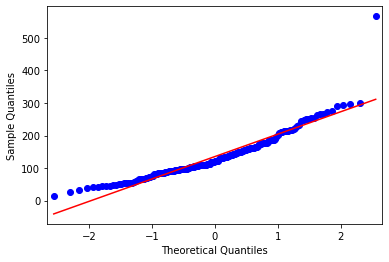

In [50]:
#We perform a qq plot then
sm.qqplot(tbs.trip_time, line='s') #.loc[hw_bcovid.hw_pos.isin([3,4])]
pylab.show()

In [47]:
#As the size of our data is bigger than 5000, Shapiro-Test will almost always reject the Null Hypothesis
stats.shapiro(tbs_covid.trip_time)

(0.9315587878227234, 8.205439883113286e-09)

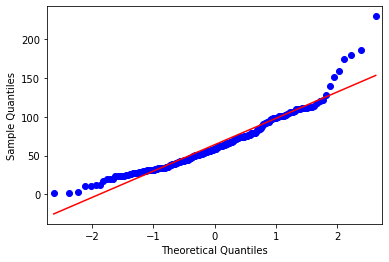

In [49]:
#We perform a qq plot then
sm.qqplot(tbs_covid.trip_time, line='s') #.loc[hw_bcovid.hw_pos.isin([3,4])]
pylab.show()

In [56]:
welch_ttest(tbs.trip_time,tbs_covid.trip_time)


 Welch's t-test= 12.9273 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 263.1189
Nb = 189, Mean b = 135.19869995117188, Sb = 68.96465778525621
Nb = 228, Mean b = 64.06928253173828, Sb = 34.13347679743817


## COMPARISON OF TIMES BETWEEN STOPS BEFORE AND AFTER CORONAVIRUS

In [10]:
#Comparison of data
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=tbs.trip_time,name='Before COVID-19',
    histnorm='probability',
    xbins=dict(
        size=5
    )
))
fig.add_trace(go.Histogram(
    x=tbs_covid.trip_time,name='While COVID-19',
    histnorm='probability',
    xbins=dict(
        size=10
    )
))
# Overlay both histograms
fig.update_layout(
    title='Lapsed Time from stop {} to {} of line {} in {} days. {}:00-{}:00.'.format(stopA,stopB,line,day_type,st_hour,end_hour),
    xaxis_title='Seconds',
    yaxis_title='Normalized Count'
)
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [11]:
#Comparison of data
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=tbs.api_trip_time,name='Before COVID-19',
    histnorm='probability',
    xbins=dict(
        size=5
    )
))
fig.add_trace(go.Histogram(
    x=tbs_covid.api_trip_time,name='While COVID-19',
    histnorm='probability',
    xbins=dict(
        size=10
    )
))
# Overlay both histograms
fig.update_layout(
    title='API Time from stop {} to {} of line {} in {} days. {}:00-{}:00.'.format(stopA,stopB,line,day_type,st_hour,end_hour),
    xaxis_title='Seconds',
    yaxis_title='Normalized Count'
)
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [12]:
#API vs Lapsed data
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=tbs.trip_time,name='Lapsed time - Before COVID-19',
    histnorm='probability',
    xbins=dict(
        size=5
    )
))
fig.add_trace(go.Histogram(
    x=tbs.api_trip_time,name='API time - Before COVID-19',
    histnorm='probability',
    xbins=dict(
        size=10
    )
))
# Overlay both histograms
fig.update_layout(
    title='API Time from stop {} to {} of line {} in {} days. {}:00-{}:00.'.format(stopA,stopB,line,day_type,st_hour,end_hour),
    xaxis_title='Seconds',
    yaxis_title='Normalized Count'
)
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [13]:
#API vs Lapsed data
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=tbs_covid.trip_time,name='Lapsed time - While COVID-19',
    histnorm='probability',
    xbins=dict(
        size=5
    )
))
fig.add_trace(go.Histogram(
    x=tbs_covid.api_trip_time,name='API time - While COVID-19',
    histnorm='probability',
    xbins=dict(
        size=10
    )
))
# Overlay both histograms
fig.update_layout(
    title='API Time from stop {} to {} of line {} in {} days. {}:00-{}:00.'.format(stopA,stopB,line,day_type,st_hour,end_hour),
    xaxis_title='Seconds',
    yaxis_title='Normalized Count'
)
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

## Two samples Z test to check if the data before COVID is different to the data while it

In [14]:
N = min(tbs.shape[0],tbs_covid.shape[0])

#Test data ramdom sample size N selection
test_data1 = tbs
test_data2 = tbs_covid

#test_data1 = tbs.sample(N) 
#test_data2 = tbs_covid.sample(N)

#Mean to test
mean_to_test = test_data1.trip_time.mean()

print('Null Hypothesis : Mean travel time during the coronavirus is equal to the mean travel time before it')

#Hyp. test
ztest ,pval1 = stests.ztest(x1=test_data2.trip_time, value=mean_to_test,alternative='two-sided')
print('p-Value = {}'.format(pval1))
if pval1 < 0.05 : 
    print('Null hypothesis rejected.')
else :
    print('Null hyphotesis is not rejected.')

Null Hypothesis : Mean travel time during the coronavirus is equal to the mean travel time before it


NameError: name 'stests' is not defined

In [ ]:
print('Null hypothesis : Mean travel time of the API is adapted to COVID status')
#Mean to test 
mean_to_test = test_data2.trip_time.mean()

#Hyp. test
ztest ,pval1 = stests.ztest(x1=test_data2.api_trip_time, value=mean_to_test,alternative='two-sided')
print('p-Value = {}'.format(pval1))
if pval1 < 0.05 : 
    print('Null hypothesis rejected.')
else :
    print('Null hyphotesis is not rejected.')

In [ ]:
print('Null hypothesis : API mean travel time is the same as the one before COVID-19')
#Mean to test 
mean_to_test = test_data1.api_trip_time.mean()

#Hyp. test
ztest ,pval1 = stests.ztest(x1=test_data2.api_trip_time, value=mean_to_test,alternative='two-sided')
print('p-Value = {}'.format(pval1))
if pval1 < 0.05 : 
    print('Null hypothesis rejected.')
else :
    print('Null hyphotesis is not rejected.')

# NOW THAT WE  HAVE PROVED THAT COVID 19 HIGHLY AFFECTS THE TIMES BT STOPS, WE ARE GOING TO ANALYSE ONLY THE DATA COLLECTED BEFORE IT

## TIMES BT STOPS DEPENDING ON DAY HOUR

In [ ]:
#Rainbow set of colors
N = 24
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]
#Selection options
line = '82'
direction = 1
day_type = 'FE'
stopA = int(lines_collected_dict[line][str(direction)]['stops'][1])
stopB = int(lines_collected_dict[line][str(direction)]['stops'][2])

#Select data
sel_df = times_bt_stops.loc[(times_bt_stops.line == line) & \
                      (times_bt_stops.direction == direction) & \
                      (times_bt_stops.date.dt.weekday.isin(day_type_dict[day_type])) & \
                      (times_bt_stops.stopA == stopA) & (times_bt_stops.stopB == stopB)]
sel_df = sel_df.loc[sel_df.date<covid_start]

#Create figure
fig = go.Figure()
#Hour selection and traces
hour_dfs = []
for i in range(N) :
    hour_df = sel_df.loc[sel_df.st_hour == i]
    hour_dfs.append(hour_df)
    length = hour_df.shape[0]
    if length > 0 :
        x1 = ['{}:00'.format(i) for elem in range(length)]
        x_real = ['Lapsed' for elem in range(length)]
        x_API = ['API' for elem in range(length)]
        #Add hour trace
        fig.add_trace(go.Box(
            x=[x1,x_real],
            y=hour_df.trip_time,
            marker_color=c[i]
        ))
        fig.add_trace(go.Box(
            x=[x1,x_API],
            y=hour_df.api_trip_time,
            marker_color=c[i]
        ))

#Layout
fig.update_layout(
    title='Time from stop {} to {} of line {} in {} days'.format(stopA,stopB,line,day_type),
    showlegend=False,
    xaxis=dict(title='Start Hour'),
    yaxis=dict(title='Seconds',range=[0,300]),
)

fig.show()

## ERROR BETWEEN API ESTIMATIONS AND REAL RUNNING TIME BT STOPS

In [ ]:
#Select covid and no covid data
times_bt_stops_bc = times_bt_stops.loc[times_bt_stops.date < covid_start]

In [ ]:
def get_running_time_error(row):
    seconds = row.api_trip_time - row.trip_time
    row['estim_error'] = round(seconds,3)
    row['sq_estim_error'] = round(seconds**2,3)
    return row

tbs_error = times_bt_stops_bc.loc[times_bt_stops.line == '1'].apply(get_running_time_error, axis=1)

In [ ]:
#Before COVID-19 Histogram of Estimation Errors
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=tbs_error.estim_error,
    histnorm='probability',
    xbins=dict(
        size = 1
    )
))
fig.update_layout(
    title = 'Running time API estimations error',
    yaxis_title = 'Normalized Count',
    xaxis_title = 'Seconds'
)
fig.show()

In [ ]:
def compute_results(df) :
    N = df.shape[0] 
    rmse = math.sqrt(df.sq_estim_error.sum()/N)
    mean_error = df.estim_error.sum()/N
    
    def estim_deviation(row) :
        return (mean_error-row.estim_error)**2
    
    df['estim_dev'] = df.apply(estim_deviation, axis=1)
    
    std_error = math.sqrt(df.estim_dev.sum()/N-1)
    
    return rmse,mean_error,std_error

rmse,mean_error,std_error = compute_results(tbs_error)

In [ ]:
rmse,mean_error,std_error

In [13]:
#Process mean times between stops
tims_bt_stops = times_bt_stops.loc[(times_bt_stops.line == line) & \
                                    (times_bt_stops.date.dt.weekday.isin([0,1,2,3,4])) & \
                                    (times_bt_stops.st_hour >= 10) & \
                                    (times_bt_stops.st_hour < 11)]
#Group and get the mean values
tims_bt_stops = tims_bt_stops.groupby(['line','direction','stopA','stopB']).mean()
tims_bt_stops = tims_bt_stops.reset_index()[['line','direction','stopA','stopB','trip_time','api_trip_time']]

In [19]:
tims_bt_stops[tims_bt_stops.direction == 2].trip_time.sum()

3948.1016